<h1>Bayes classifier with a Gaussian distribution for every class<h1>

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from math import sqrt
%matplotlib inline

plt.rcParams["font.size"] = 18
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = 8,6
plt.rcParams['font.serif'] = "Cambria"
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.family'] = 'DejaVu Sans'

In [36]:
# First, let's load the CSV files to inspect the data and understand their structure.

import pandas as pd

# Load the datasets
train_df = pd.read_csv('Dataset-1/train.csv')
test_df = pd.read_csv('Dataset-1/test.csv')
val_df = pd.read_csv('Dataset-1/val.csv')

# Displaying the first few rows of each dataset to understand the structure
train_df.head(), test_df.head(), val_df.head()


(         x1        x2  label
 0 -6.910217 -0.326715    1.0
 1  5.545413  2.247870    0.0
 2 -0.131283 -5.622213    2.0
 3 -2.647632 -5.290210    2.0
 4 -1.884303 -4.804899    2.0,
          x1        x2  label
 0 -2.992613  1.514989    1.0
 1  5.309101  0.272428    0.0
 2  3.017600  0.608599    0.0
 3  3.403016  0.948097    0.0
 4 -2.990241 -4.730480    1.0,
          x1        x2  label
 0 -1.781862 -5.514588    2.0
 1  5.012229  0.422650    0.0
 2  5.022045 -1.632215    0.0
 3  2.784067 -2.474284    0.0
 4  3.856569  0.307883    0.0)

In [37]:
# Load the data (assuming train_df, test_df, val_df have been loaded)
x_train = train_df[['x1', 'x2']].values
y_train = train_df['label'].values
x_test = test_df[['x1', 'x2']].values
y_test = test_df['label'].values
x_val = val_df[['x1', 'x2']].values
y_val = val_df['label'].values

In [38]:
# Function to evaluate the accuracy of predictions
def evaluate_accuracy(y_true, y_pred):
    correct = np.sum(np.array(y_true) == np.array(y_pred))
    return correct / len(y_true)

# Function to evaluate performance and print accuracy and confusion matrix
def evaluate_classifier(y_true, y_pred, dataset_name):
    accuracy = evaluate_accuracy(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Accuracy on {dataset_name}: {accuracy}")
    plot_confusion_matrix(y_true, y_pred, title=f"Confusion Matrix on {dataset_name}")
    
    return accuracy, cm

In [39]:
def estimate_gaussian_parameters(x_train, y_train):
    classes = np.unique(y_train)
    params = {}
    params_avg_cov = {}
    total_cov = 0
    
    for cls in classes:
        # Select data points for the current class
        class_data = x_train[y_train == cls]
        
        # Estimate mean and covariance
        mean = np.mean(class_data, axis=0)
        cov = np.cov(class_data, rowvar=False)
        
        # Add the covariance to the total
        total_cov += cov
        
        # Store the parameters for this class
        params[cls] = {'mean': mean, 'cov': cov}
    
    # Calculate the average covariance
    avg_cov = total_cov / len(classes)
    for cls in classes:
        params_avg_cov[cls] = {'mean': params[cls]['mean'], 'cov': avg_cov}
    
    return params, params_avg_cov

In [40]:
from scipy.stats import multivariate_normal

# Function to compute the multivariate Gaussian likelihood
def gaussian_pdf(x, mean, cov):
    # Create a multivariate Gaussian distribution object
    dist = multivariate_normal(mean=mean, cov=cov)
    
    # Return the probability density for the point x
    return dist.pdf(x)

# Bayes classifier function
def bayes_classifier(x_train, y_train, test_data, params):
    predictions = []
    classes = np.unique(y_train)

    # Loop over each test data point
    for x in test_data:
        posteriors = {}

        # Calculate posterior probability for each class
        for cls in classes:
            mean = params[cls]['mean']
            cov = params[cls]['cov']

            # Likelihood of x given class
            likelihood = gaussian_pdf(x, mean, cov)

            # Prior is assumed to be uniform, so we only consider the likelihood
            posteriors[cls] = likelihood

        # Assign to the class with the highest posterior
        predicted_class = max(posteriors, key=posteriors.get)
        predictions.append(predicted_class)

    return predictions



In [41]:
# Function to plot confusion matrix with customized font sizes
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))

    # Set title and labels with specific font sizes
    plt.title(title, fontsize=12)
    plt.xlabel('Predicted Label', fontsize=10)
    plt.ylabel('True Label', fontsize=10)

    # Optionally adjust tick label sizes
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.show()


In [42]:
def plot_decision_boundary_bayes(x_train, y_train, params, h=0.1):
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    # Define the min and max for the grid based on training data
    x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
    y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1

    # Generate a grid of points
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Flatten the grid to pass into the prediction function
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Use Bayes classifier to predict the class for each grid point
    Z = bayes_classifier(x_train, y_train, grid_points, params)

    # Reshape the result back into the grid shape
    Z = np.array(Z).reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot the training points
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=50)

    plt.title("Decision Boundary for Bayes Classifier")
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()


In [43]:
# Estimate the Gaussian parameters from the training data
params, params_avg_cov = estimate_gaussian_parameters(x_train, y_train)

<h1>a. Covariance matrices for all the classes are the same<h1>

In [44]:
train_predictions = bayes_classifier(x_train, y_train, x_train, params_avg_cov)
val_predictions = bayes_classifier(x_train, y_train, x_val, params_avg_cov)
test_predictions = bayes_classifier(x_train, y_train, x_test, params_avg_cov)

# Calculate accuracy for each dataset
train_accuracy = evaluate_accuracy(y_train, train_predictions)
val_accuracy = evaluate_accuracy(y_val, val_predictions)
test_accuracy = evaluate_accuracy(y_test, test_predictions)

# Create a dictionary to hold the data
data = {
    'Dataset': ['Train', 'Validation', 'Test'],
    'Size': [len(x_train), len(x_val), len(x_test)],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy]
}

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)

      Dataset  Size  Accuracy
0       Train   840  0.984524
1  Validation   240  0.983333
2        Test   120  0.983333



Covariance matrices for all the classes are the same

Accuracy on Test Data: 0.9833333333333333


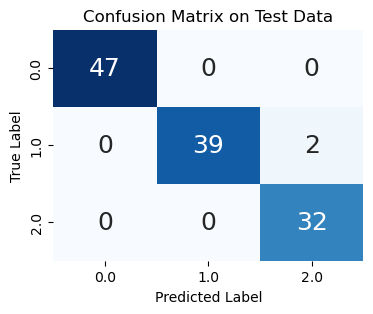

Accuracy on Validation Data: 0.9833333333333333


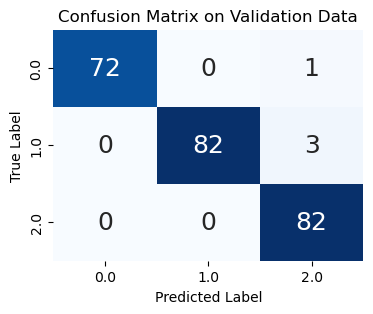

Accuracy on Train Data: 0.9845238095238096


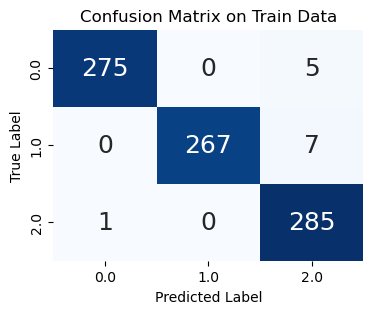

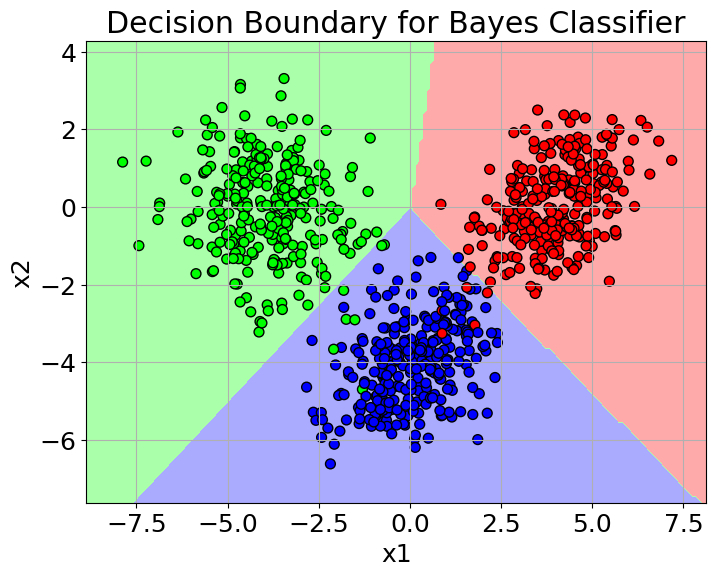

In [45]:
# Estimate the Gaussian parameters from the training data
# params, params_avg_cov = estimate_gaussian_parameters(x_train, y_train)
print("\nCovariance matrices for all the classes are the same\n")
# Run Bayes classifier for test, validation, and training data
for dataset_name, x_data, y_data in [("Test Data", x_test, y_test), 
                                     ("Validation Data", x_val, y_val), 
                                     ("Train Data", x_train, y_train)]:
    
    # Predict using Bayes classifier for different Covariance
    predictions = bayes_classifier(x_train, y_train, x_data, params_avg_cov)
    
    # Evaluate the classifier
    evaluate_classifier(y_data, predictions, dataset_name)

# Plot decision boundary for Bayes classifier
plot_decision_boundary_bayes(x_train, y_train, params_avg_cov)


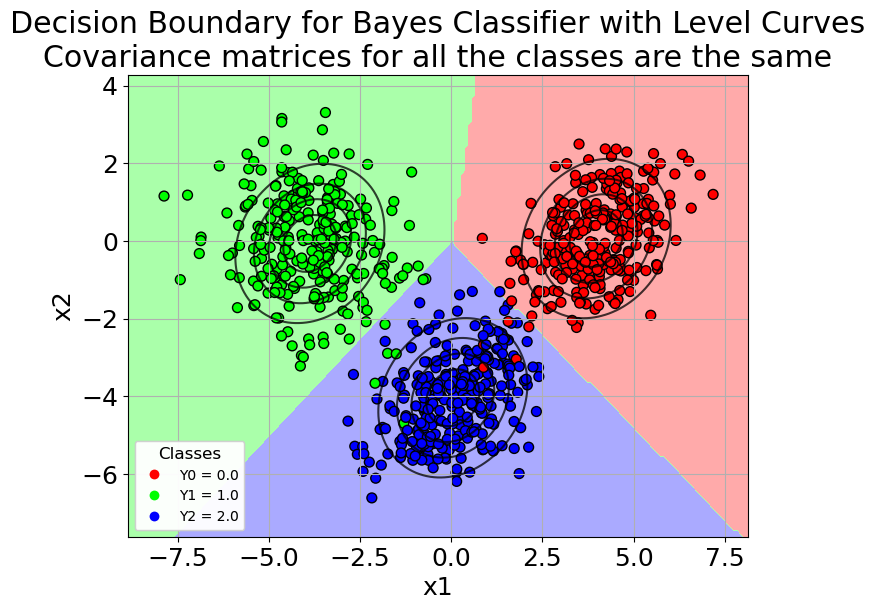

In [46]:
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

# Function to plot decision boundary and level curves for Bayes classifier
def plot_decision_boundary_bayes_with_curves(x_train, y_train, h=0.1):
    unique_classes = np.unique(y_train)
    n_classes = len(unique_classes)

    # Generate color maps based on the number of classes
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])  # Light colors for decision regions
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])   # Bold colors for training points

    # Define the min and max for the grid based on training data
    x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
    y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1

    # Generate a grid of points
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Flatten the grid to pass into the prediction function
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Use the Bayes classifier to predict the class for each grid point for different covariance
    Z = bayes_classifier(x_train, y_train, grid_points, params_avg_cov)

    # Reshape the result back into the grid shape
    Z = np.array(Z).reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot the training points
    scatter = plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=50)

    # Add dynamic class labels to the legend
    legend1 = plt.legend(handles=scatter.legend_elements()[0],
                         labels=[f"Y{i} = {label}" for i, label in enumerate(unique_classes)],
                         loc='lower left', title='Classes', fontsize='10', title_fontsize='12')
    plt.gca().add_artist(legend1)

    # Add level curves for each class
    for cls in unique_classes:
        # Extract the points of the current class
        class_data = x_train[y_train == cls]

        # Compute mean and covariance of the current class
        mean = params_avg_cov[cls]['mean']
        cov = params_avg_cov[cls]['cov']

        # Create a multivariate normal distribution with the calculated mean and covariance
        rv = multivariate_normal(mean=mean, cov=cov)

        # Compute PDF values for the grid points
        pdf_values = rv.pdf(grid_points).reshape(xx.shape)

        # Plot level curves based on the PDF
        plt.contour(xx, yy, pdf_values, levels=5, alpha=0.75, colors='black')

    # Add labels, title, and limits
    plt.title("Decision Boundary for Bayes Classifier with Level Curves\nCovariance matrices for all the classes are the same")
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

# Plot decision boundary and level curves for Bayes classifier
plot_decision_boundary_bayes_with_curves(x_train, y_train)


<h1>b. Covariance matrices are different<h1>

In [47]:
train_predictions = bayes_classifier(x_train, y_train, x_train, params)
val_predictions = bayes_classifier(x_train, y_train, x_val, params)
test_predictions = bayes_classifier(x_train, y_train, x_test, params)

# Calculate accuracy for each dataset
train_accuracy = evaluate_accuracy(y_train, train_predictions)
val_accuracy = evaluate_accuracy(y_val, val_predictions)
test_accuracy = evaluate_accuracy(y_test, test_predictions)

# Create a dictionary to hold the data
data = {
    'Dataset': ['Train', 'Validation', 'Test'],
    'Size': [len(x_train), len(x_val), len(x_test)],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy]
}

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)

      Dataset  Size  Accuracy
0       Train   840  0.983333
1  Validation   240  0.991667
2        Test   120  0.991667



Covariance matrices are different

Accuracy on Test Data: 0.9916666666666667


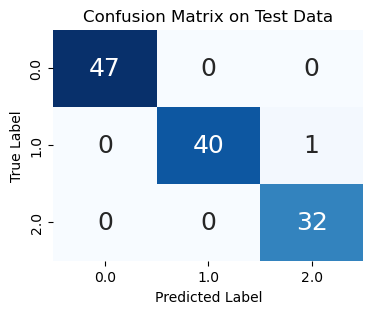

Accuracy on Validation Data: 0.9916666666666667


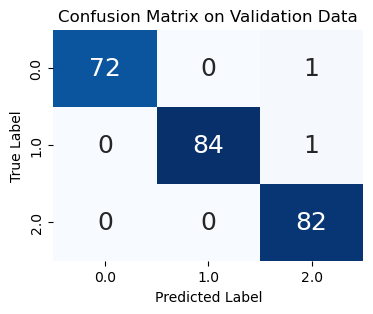

Accuracy on Train Data: 0.9833333333333333


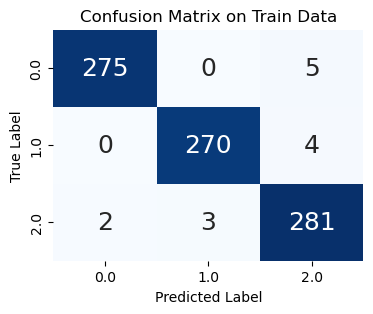

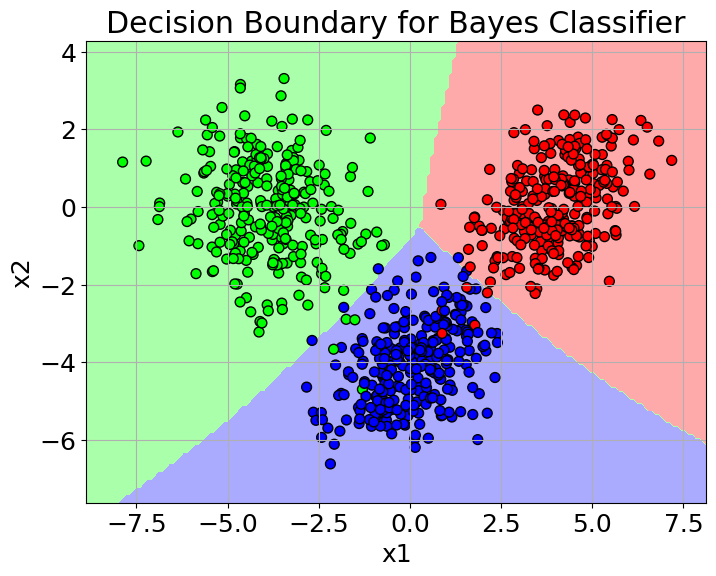

In [48]:

print("\nCovariance matrices are different\n")

# Run Bayes classifier for test, validation, and training data
for dataset_name, x_data, y_data in [("Test Data", x_test, y_test), 
                                     ("Validation Data", x_val, y_val), 
                                     ("Train Data", x_train, y_train)]:
    
    # Predict using Bayes classifier for different Covariance
    predictions = bayes_classifier(x_train, y_train, x_data, params)
    
    # Evaluate the classifier
    evaluate_classifier(y_data, predictions, dataset_name)

# Plot decision boundary for Bayes classifier
plot_decision_boundary_bayes(x_train, y_train, params)


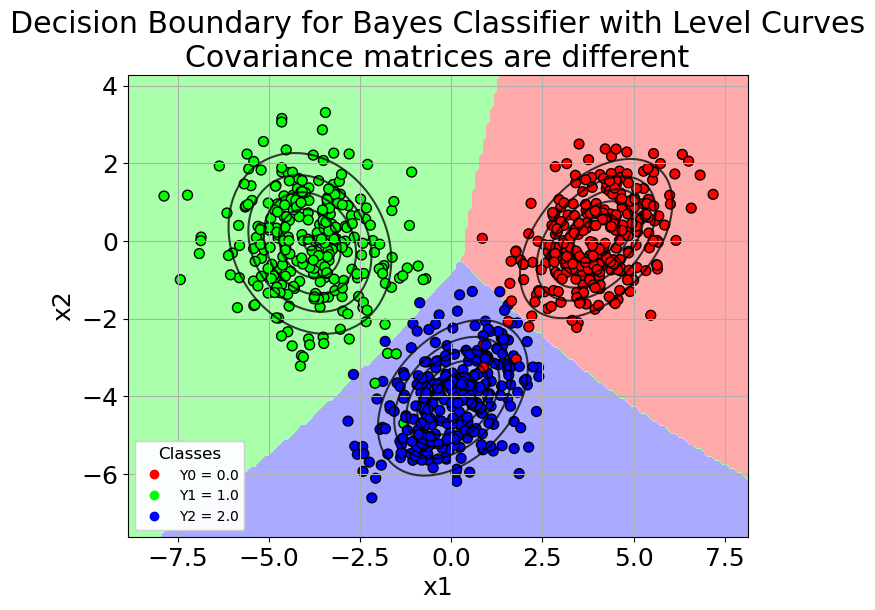

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

# Function to plot decision boundary and level curves for Bayes classifier
def plot_decision_boundary_bayes_with_curves(x_train, y_train, h=0.1):
    unique_classes = np.unique(y_train)
    n_classes = len(unique_classes)

    # Generate color maps based on the number of classes
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])  # Light colors for decision regions
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])   # Bold colors for training points

    # Define the min and max for the grid based on training data
    x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
    y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1

    # Generate a grid of points
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Flatten the grid to pass into the prediction function
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Use the Bayes classifier to predict the class for each grid point for different covariance
    Z = bayes_classifier(x_train, y_train, grid_points, params)

    # Reshape the result back into the grid shape
    Z = np.array(Z).reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot the training points
    scatter = plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=50)

    # Add dynamic class labels to the legend
    legend1 = plt.legend(handles=scatter.legend_elements()[0],
                         labels=[f"Y{i} = {label}" for i, label in enumerate(unique_classes)],
                         loc='lower left', title='Classes', fontsize='10', title_fontsize='12')
    plt.gca().add_artist(legend1)

    # Add level curves for each class
    for cls in unique_classes:
        # Extract the points of the current class
        class_data = x_train[y_train == cls]

        # Compute mean and covariance of the current class
        mean = params[cls]['mean']
        cov = params[cls]['cov']

        # Create a multivariate normal distribution with the calculated mean and covariance
        rv = multivariate_normal(mean=mean, cov=cov)

        # Compute PDF values for the grid points
        pdf_values = rv.pdf(grid_points).reshape(xx.shape)

        # Plot level curves based on the PDF
        plt.contour(xx, yy, pdf_values, levels=5, alpha=0.75, colors='black')

    # Add labels, title, and limits
    plt.title("Decision Boundary for Bayes Classifier with Level Curves\nCovariance matrices are different")
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

# Plot decision boundary and level curves for Bayes classifier
plot_decision_boundary_bayes_with_curves(x_train, y_train)
